In [1]:
import os
import json
from glob import glob
from collections import namedtuple

import torch
import numpy as np
import matplotlib.pyplot as plt

from bbb.utils.pytorch_setup import DEVICE
from bbb.config.constants import KL_REWEIGHTING_TYPES, PRIOR_TYPES, VP_VARIANCE_TYPES
from bbb.config.parameters import Parameters, PriorParameters
from bbb.models.dnn import ClassificationDNN
from bbb.models.bnn import ClassificationBNN
from bbb.data import load_mnist

## Helper Classes

In [2]:
ModelDetails = namedtuple('ModelDetails', 'dir mclass')

## Trained Classification Models

In [3]:
MODEL_DETAILS_DICT = {
    # BNN
    "bnn_1200": ModelDetails("../saved_models/BBB_classification/2022-03-15-09.18.07", ClassificationBNN),
    "bnn_800": ModelDetails("../saved_models/BBB_classification/2022-03-15-14.25.46", ClassificationBNN),
    "bnn_400": ModelDetails("../saved_models/BBB_classification/2022-03-15-14.26.34", ClassificationBNN),
    # DNN - no dropout
    "dnn_1200": ModelDetails("../saved_models/DNN_classification/2022-03-15-14.28.25", ClassificationDNN),
    "dnn_800": ModelDetails("../saved_models/DNN_classification/2022-03-15-16.06.09", ClassificationDNN),
    "dnn_400": ModelDetails("../saved_models/DNN_classification/2022-03-15-16.10.34", ClassificationDNN),
    # DNN - dropout
    "dnn_do_1200": ModelDetails("../saved_models/DNN_classification/2022-03-15-15.21.46", ClassificationDNN),
    "dnn_do_1200": ModelDetails("../saved_models/DNN_classification/2022-03-15-15.58.04", ClassificationDNN),
    "dnn_do_1200": ModelDetails("../saved_models/DNN_classification/2022-03-15-16.26.18", ClassificationDNN),
}

## Set Model

In [4]:
MODEL = "bnn_1200"
MODEL_DETAILS = MODEL_DETAILS_DICT[MODEL]
MODEL_DETAILS

ModelDetails(dir='../saved_models/BBB_classification/2022-03-15-09.18.07', mclass=<class 'bbb.models.bnn.ClassificationBNN'>)

## Load Parameters

In [5]:
with open(os.path.join(MODEL_DETAILS.dir, 'params.txt'), 'r') as f:
    params_dict = json.load(f)

# Need to deserialise the prior_params into a PriorParameters object
if params_dict['prior_params']:
    params_dict['prior_params'] = PriorParameters(**params_dict['prior_params'])

params = Parameters(**params_dict)
params

Parameters(name='BBB_classification', input_dim=784, output_dim=10, batch_size=128, epochs=300, hidden_units=1200, hidden_layers=3, lr=0.0001, step_size=75, opt_choice='Adam', gamma=0.1, weight_mu_range=[-0.2, 0.2], weight_rho_range=[-5, -4], prior_params=PriorParameters(w_sigma=1.0, b_sigma=1.0, w_sigma_2=0.2, b_sigma_2=0.2, w_mixture_weight=0.5, b_mixture_weight=0.5), elbo_samples=2, inference_samples=10, regression_likelihood_noise=None, kl_reweighting_type=1, vp_variance_type=1, prior_type=0, local_reparam_trick=False, dropout=False, dropout_p=None, early_stopping=False, early_stopping_thresh=0, model_save_basedir='./saved_models', tensorboard_save_dir='./tensorboard')

## Load Data

In [6]:
X_val = load_mnist(train=False, batch_size=params.batch_size, shuffle=True)

/Users/alanclark/git/BBB/.venv/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Load Model

In [7]:
net = MODEL_DETAILS.mclass(params=params, eval_mode=True).to(DEVICE)
net.model.load_state_dict(torch.load(os.path.join(MODEL_DETAILS.dir, 'model.pt'), map_location=torch.device('cpu')))

2022-03-15 17:42:59,387 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-15 17:42:59,388 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0
2022-03-15 17:42:59,404 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-15 17:42:59,404 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0
2022-03-15 17:42:59,407 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-15 17:42:59,407 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0


<All keys matched successfully>

## Evaluate

In [8]:
net.evaluate(X_val)

tensor(0.9842)

## Recorded Metrics

In [9]:
eval_metric = np.load(os.path.join(MODEL_DETAILS.dir, 'eval_metric.npy'))

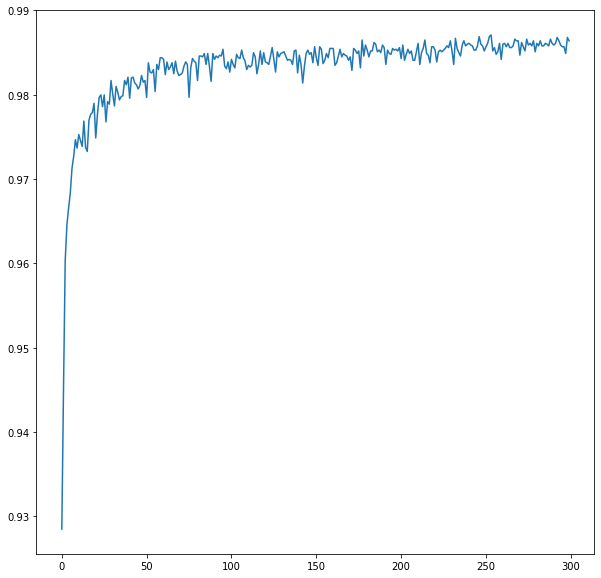

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.plot(eval_metric)

In [11]:
loss = np.load(os.path.join(MODEL_DETAILS.dir, 'loss.npy'))

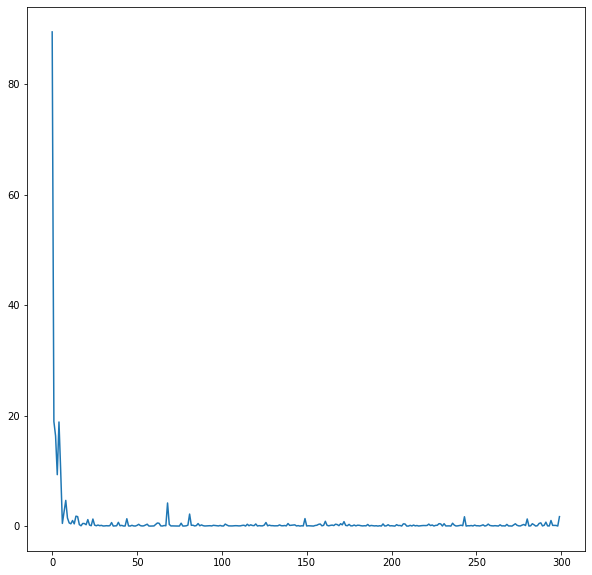

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.plot(loss)